In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
train_datapath = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'
test_datapath = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

In [5]:
full_train_dataset = datasets.ImageFolder(train_datapath, transform=train_transform)
test_dataset = datasets.ImageFolder(test_datapath, transform=test_transform)

In [6]:
train_size = int(0.8 * len(full_train_dataset))  
val_size = len(full_train_dataset) - train_size 

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [16]:
class_names = full_train_dataset.classes

In [17]:
class_names

['BA- cellulitis',
 'BA-impetigo',
 'FU-athlete-foot',
 'FU-nail-fungus',
 'FU-ringworm',
 'PA-cutaneous-larva-migrans',
 'VI-chickenpox',
 'VI-shingles']

In [18]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.2MB/s]


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 25

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [21]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

Epoch 1/25, Train Loss: 2.0061, Train Accuracy: 0.2392, Val Loss: 1.4401, Val Accuracy: 0.5726
Epoch 2/25, Train Loss: 1.2494, Train Accuracy: 0.6324, Val Loss: 0.9415, Val Accuracy: 0.7735
Epoch 3/25, Train Loss: 0.8815, Train Accuracy: 0.7270, Val Loss: 0.6276, Val Accuracy: 0.8419
Epoch 4/25, Train Loss: 0.6593, Train Accuracy: 0.7973, Val Loss: 0.4232, Val Accuracy: 0.8974
Epoch 5/25, Train Loss: 0.5315, Train Accuracy: 0.8432, Val Loss: 0.3486, Val Accuracy: 0.9231
Epoch 6/25, Train Loss: 0.4610, Train Accuracy: 0.8568, Val Loss: 0.3156, Val Accuracy: 0.9188
Epoch 7/25, Train Loss: 0.4093, Train Accuracy: 0.8743, Val Loss: 0.2567, Val Accuracy: 0.9103
Epoch 8/25, Train Loss: 0.3780, Train Accuracy: 0.8905, Val Loss: 0.2464, Val Accuracy: 0.9359
Epoch 9/25, Train Loss: 0.3464, Train Accuracy: 0.9000, Val Loss: 0.2150, Val Accuracy: 0.9487
Epoch 10/25, Train Loss: 0.3079, Train Accuracy: 0.9135, Val Loss: 0.1729, Val Accuracy: 0.9530
Epoch 11/25, Train Loss: 0.2773, Train Accuracy: 

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [23]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels

In [25]:
import matplotlib.pyplot as plt
from tqdm import tqdm

Classification Report:
                            precision    recall  f1-score   support

            BA- cellulitis       0.91      0.94      0.93        34
               BA-impetigo       1.00      0.90      0.95        20
           FU-athlete-foot       0.97      1.00      0.98        32
            FU-nail-fungus       1.00      1.00      1.00        33
               FU-ringworm       1.00      0.87      0.93        23
PA-cutaneous-larva-migrans       0.96      0.92      0.94        25
             VI-chickenpox       0.97      1.00      0.99        34
               VI-shingles       0.92      1.00      0.96        33

                  accuracy                           0.96       234
                 macro avg       0.97      0.95      0.96       234
              weighted avg       0.96      0.96      0.96       234



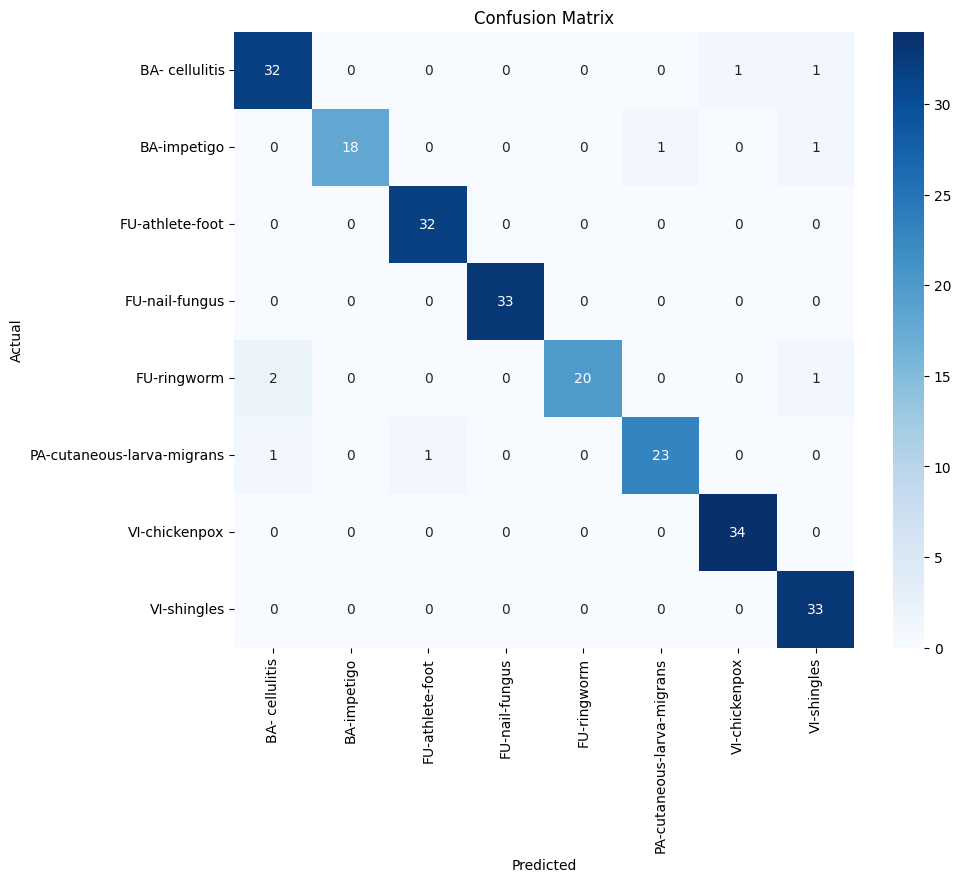

In [26]:
test_preds, test_labels = evaluate_model(model, test_loader, class_names)

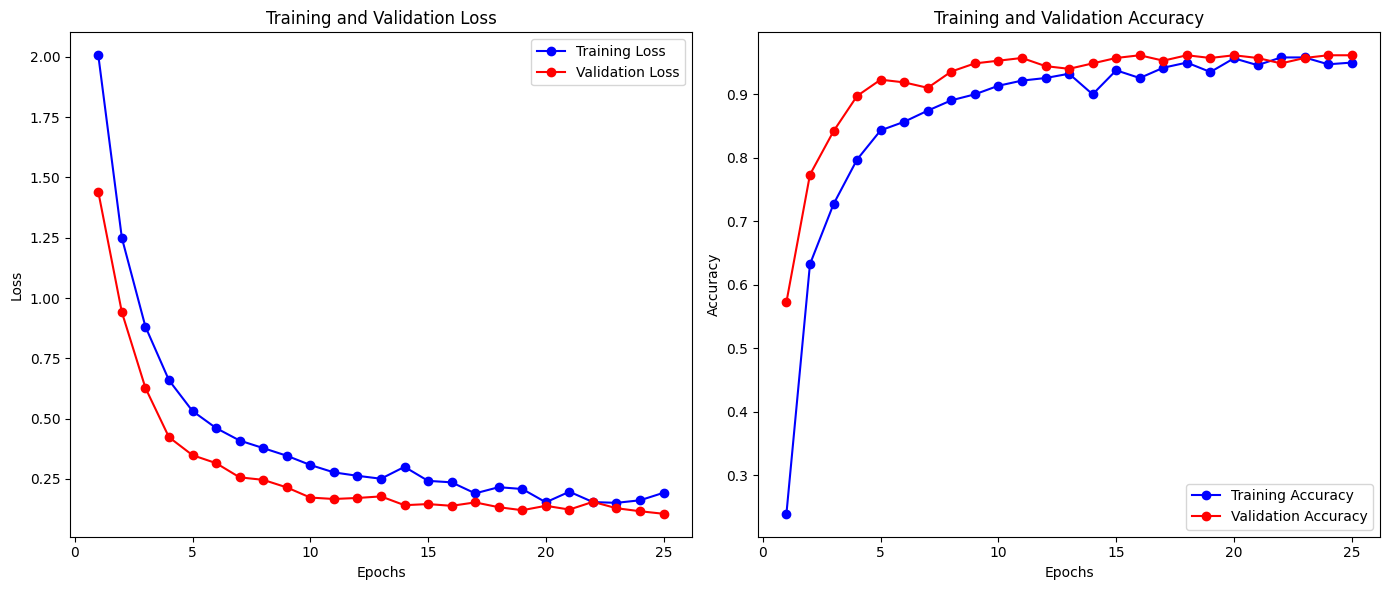

In [27]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [30]:
torch.save(model, 'skin_model_resnet.pth')

In [38]:
torch.save(model.state_dict(), 'skin_resnet_saved_model.pt')

In [31]:
def predict_image(model, image_path, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence, predicted = torch.max(probabilities, 0)
        
    return class_names[predicted.item()], confidence.item()

In [32]:
import torch.nn.functional as F

def show_predictions(model, loader, num_images=5):
    model.eval()
    all_images, all_labels, all_preds, all_confidences = [], [], [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, preds = torch.max(probabilities, 1)
            
            all_images.extend(images.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            
            if len(all_images) >= num_images:
                break
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        ax = axes[i]
        img = all_images[i].permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[all_preds[i]]} ({all_confidences[i]:.2%})\nTrue: {class_names[all_labels[i]]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


Predictions on test set:


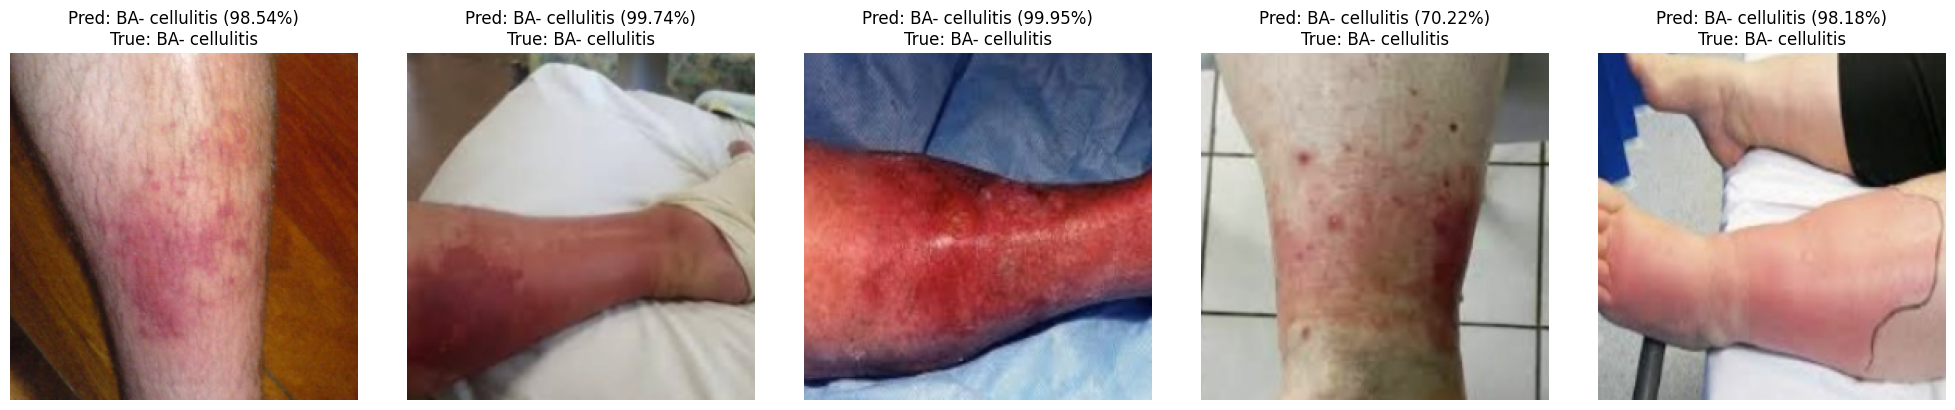

In [33]:
print("\nPredictions on test set:")
show_predictions(model, test_loader)

In [34]:

def predict_image(model, image_path, class_names):
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_idx = torch.max(output, 1)
    
    predicted_label = class_names[predicted_idx.item()]
    
    return predicted_label

In [43]:
from PIL import Image

In [45]:
image_path = '/kaggle/input/fortest1/test1.jpg'
class_names = test_dataset.classes

predicted_label = predict_image(model, image_path, class_names)
print(f"The predicted label is: {predicted_label}")

The predicted label is: VI-shingles
